In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-05-19 10:35:45.376714: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

# Imports

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 2
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-05-19 10:35:47.227821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 10:35:47.227941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 10:35:47.231133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 10:35:47.231225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 10:35:47.231305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
from orbit_generation.data import load_memmap_array, save_data
from orbit_generation.processing import resample_3d_array
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space, plot_combined_latent_space
from orbit_generation.model import get_optimizer

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-05-19 10:35:51.377529: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-19 10:35:51.378361: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7dd50f0


# Parameters

In [5]:
data_path = r"/orbit-generation/data/1p_dataset_em.npy"
labels_path = r"/orbit-generation/data/1p_dataset_em_labels.npy"
folder_experiments = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 7,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    }
}

## Create Experiment Folder

In [7]:
# Extract relevant parameters
model_name = params['model_name']
data_used = params['data_used']

# Combine the remaining parameters into a single string to form the last subdirectory name
# Excluding 'model_name' and 'data_used' since they're used in higher-level directories
other_params = f"{params['latent_dim']}_{params['feature_dim']}_{params['seq_len']}_{params['batch_size']}_{params['epochs']}_{params['optimizer']['name']}_{params['optimizer']['learning_rate']}"

# Construct the full path for the experiment directory
experiment_folder = os.path.join(folder_experiments, model_name, data_used, other_params)

# Create the directory structure
os.makedirs(experiment_folder, exist_ok=True)

# Now you can use 'experiment_folder' to save files related to this particular experiment
print(f"Experiment directory created: {experiment_folder}")

Experiment directory created: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001


In [8]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Imports

In [9]:
data = load_memmap_array(data_path)
data.shape

(36071, 7, 1500)

In [10]:
labels = np.load(labels_path)
labels.shape

(36071,)

## Interpolation

In [11]:
data = resample_3d_array(data=data, axis=2, target_size=params['seq_len'])
data.shape

(36071, 7, 300)

## Shuffle

In [12]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = labels[indices]

## Transpose

In [13]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [14]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(36071, 300, 7)

# Generation

## Define Architecture

In [15]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [16]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-05-19 10:36:17.473867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/1128 [..............................] - ETA: 58s - loss: 2587.2850 - reconstruction_loss: 2069.9504 - kl_loss: 10.6996WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0298s). Check your callbacks.


1128/1128 [==============================] - 61s 52ms/step - loss: 461.9566 - reconstruction_loss: 205.0325 - kl_loss: 19.8368
Epoch 2/25
1128/1128 [==============================] - 59s 52ms/step - loss: 71.3952 - reconstruction_loss: 37.1304 - kl_loss: 18.7075
Epoch 3/25
1128/1128 [==============================] - 59s 52ms/step - loss: 47.1761 - reconstruction_loss: 28.5606 - kl_loss: 16.4931
Epoch 4/25
1128/1128 [==============================] - 59s 52ms/step - loss: 53.6791 - reconstruction_loss: 31.8647 - kl_loss: 15.7322
Epoch 5/25
1128/1128 [==============================] - 59s 52ms/step - loss: 27.4733 - reconstruction_loss: 14.0921 - kl_loss: 13.2447
Epoch 6/25
1128/1128 [==============================] - 59s 52ms/step - loss: 29.4299 - reconstruction_loss: 18.6575 - kl_loss: 13.2991
Epoch 7/25
1128/1128 [==============================] - 59s 52ms/step - loss: 27.6634 - reconstruction_loss: 19.9942 - kl_loss: 12.5903
Epoch 8/25
1128/1128 [==============================] - 5

## Save Model

In [17]:
# Define full paths for the encoder and decoder
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')

In [18]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

wandb.save('encoder.h5')
wandb.save('decoder.h5')
wandb.save('generation.npy')

INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/decoder/assets


[]

In [19]:
"""
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
"""

'\nencoder = tf.keras.models.load_model(encoder_save_path)\ndecoder = tf.keras.models.load_model(decoder_save_path)\n\n# Assuming encoder and decoder have been defined as part of the architecture setup\nvae = tsgm.models.cvae.BetaVAE(encoder, decoder)\n'

## Predict

In [20]:
x_decoded = vae.predict(scaled_data)

1128/1128 [==============================] - 16s 14ms/step


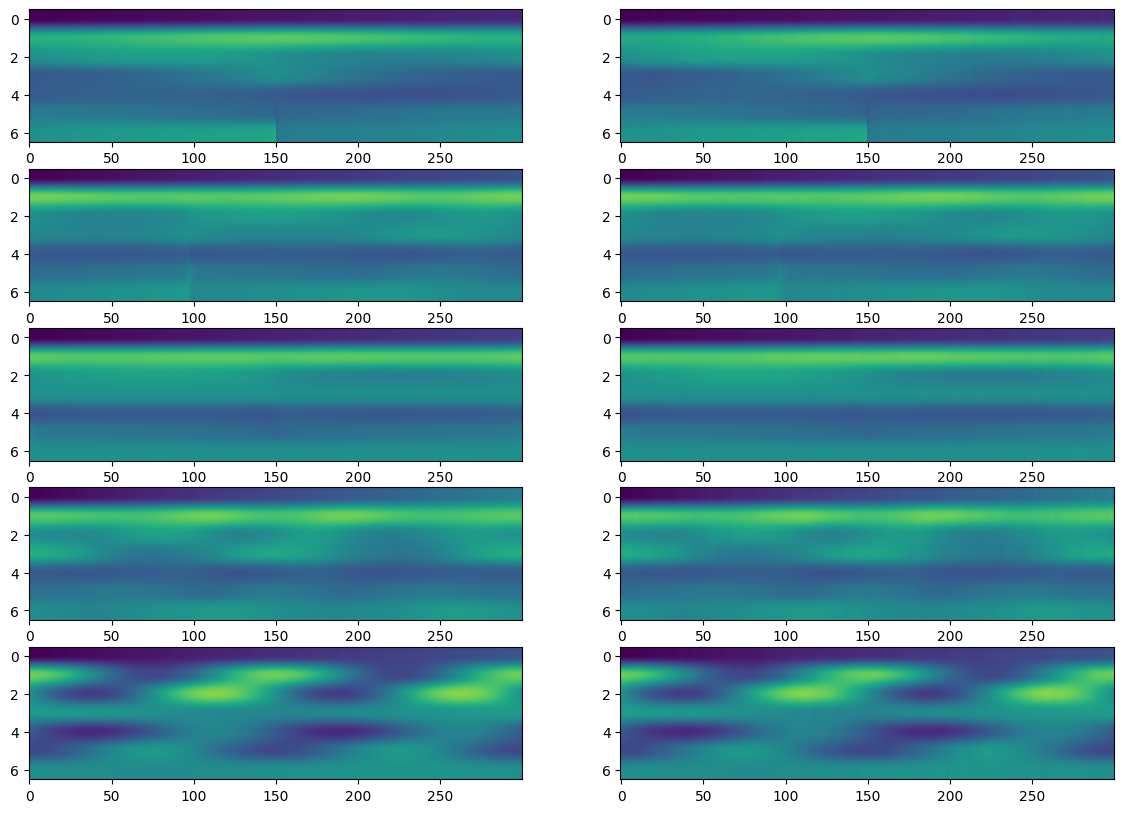

In [21]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=5)

## Generate

In [22]:
# generation = vae.generate(int(data.shape[0]*0.01))
generation = vae.generate(100)
generation.shape

TensorShape([100, 300, 7])

In [23]:
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
print(generated_data_path)

../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/generated_data.npy


In [24]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 7])

In [25]:
# generation = np.load(generated_data_path)

# Analysis

## Visualization

In [26]:
no_time_generation = inverted_generation[:,:,1:]
no_time_generation.shape

TensorShape([100, 300, 6])

In [27]:
display_generation = np.transpose(no_time_generation, (0, 2, 1))

In [28]:
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')

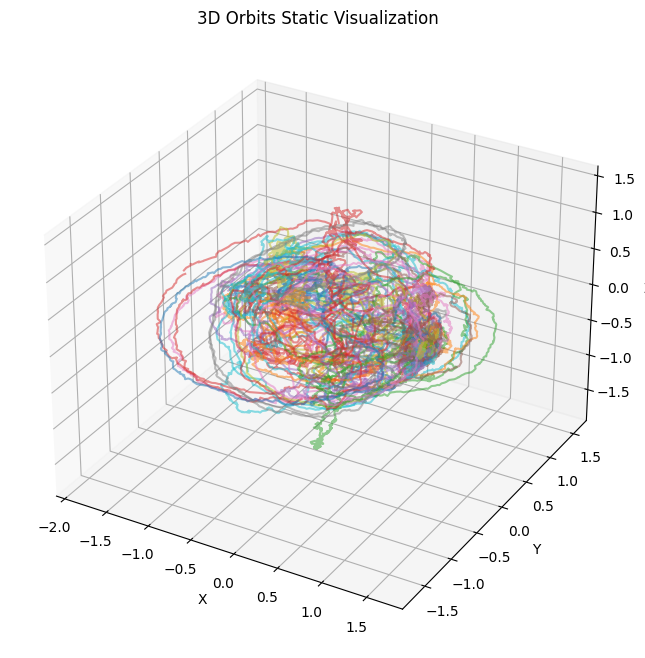

In [29]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

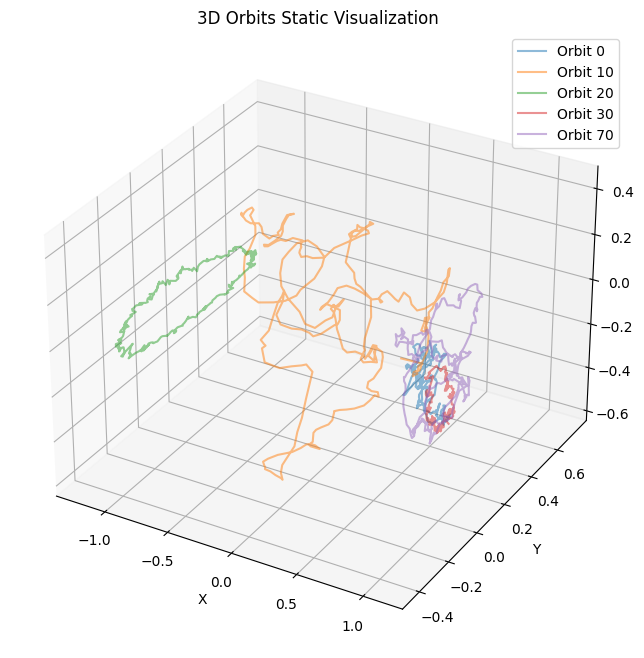

In [30]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,70], save_path=static_some_orbit_path)

In [31]:
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/generated_orbits.html


## Coverage

In [32]:
data.shape

(36071, 7, 300)

In [33]:
inverted_ordered_generation = np.transpose(inverted_generation, (0, 2, 1))
inverted_ordered_generation.shape

(100, 7, 300)

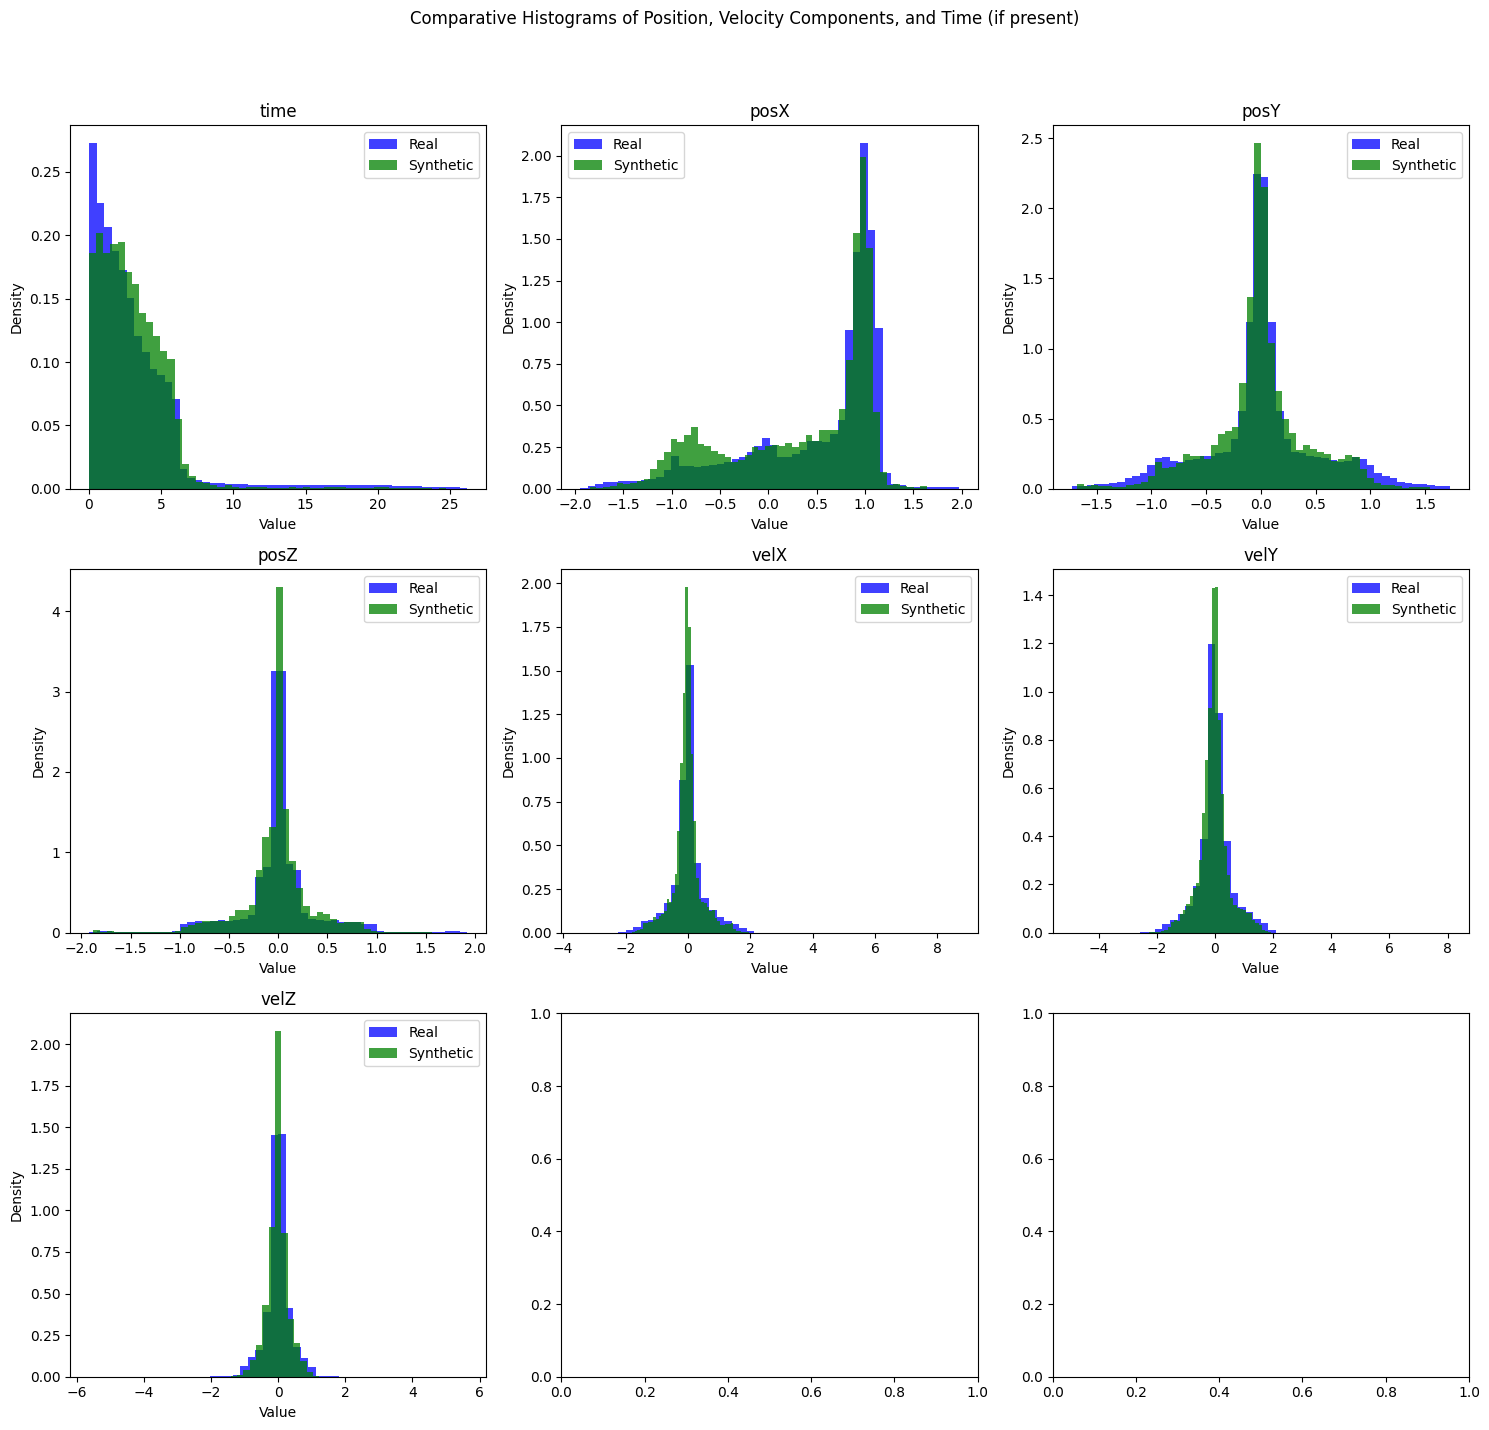

In [34]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Latent Visualization

In [35]:
np.random.seed(42)

# Number of samples to draw
num_samples = 1000

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=num_samples, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(1000, 300, 7)

In [36]:
latent_mean, _, _ = vae.encoder(sampled_data)
latent_representations = latent_mean.numpy()

In [37]:
latent_space_path = os.path.join(experiment_folder, 'latent_space')
combined_latent_space_path = os.path.join(experiment_folder, 'combined_latent_space')

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_PCA.png


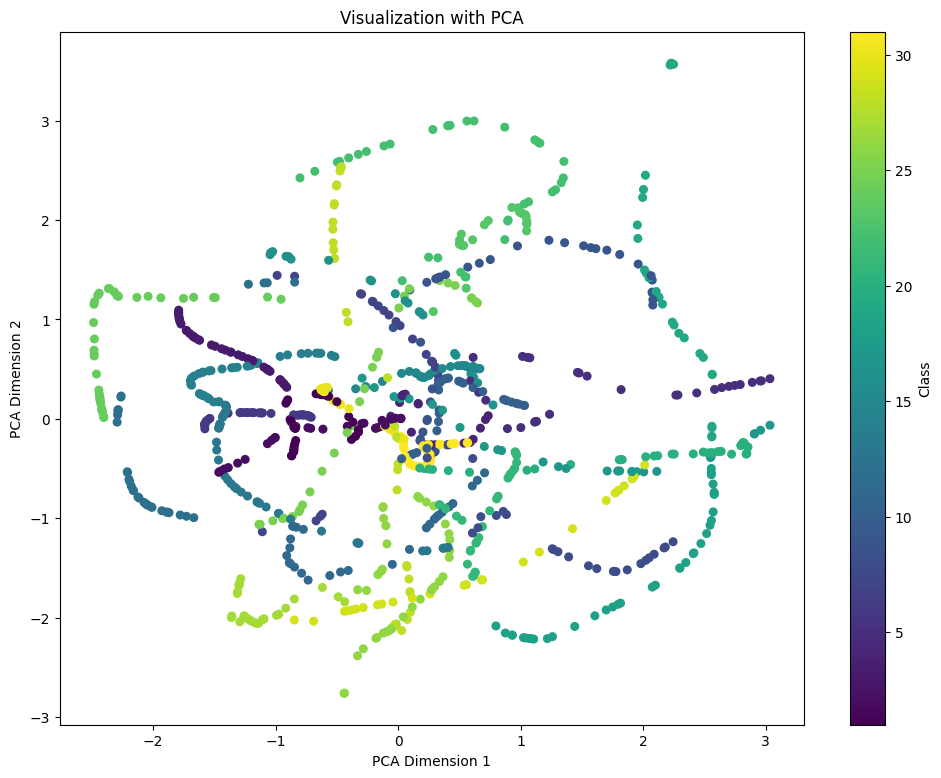

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_t-SNE.png


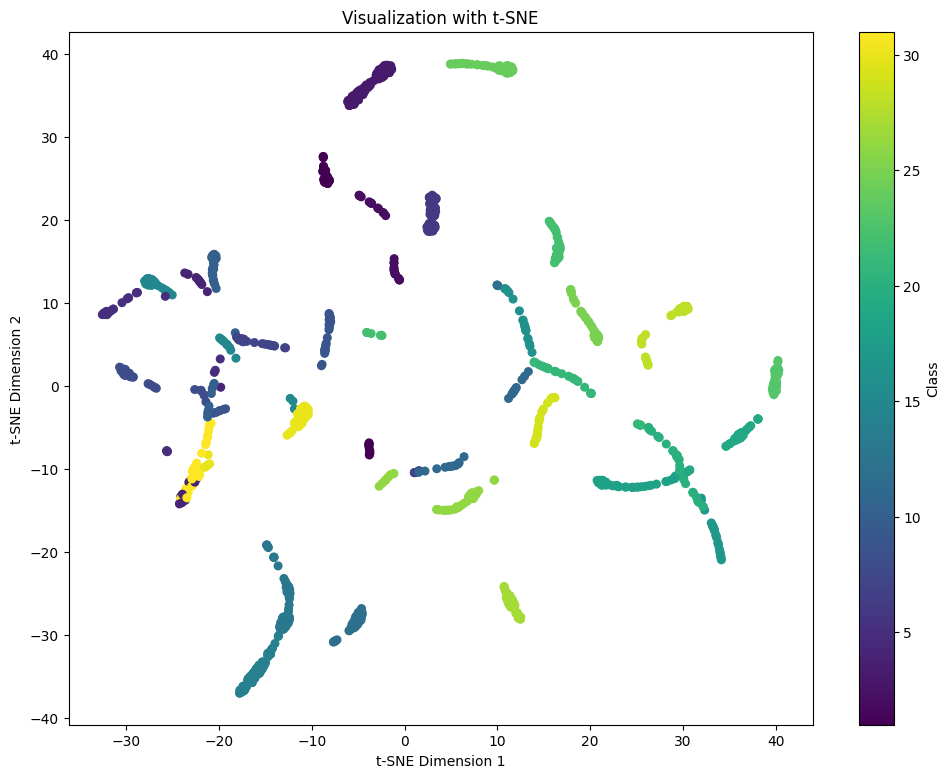

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_UMAP.png


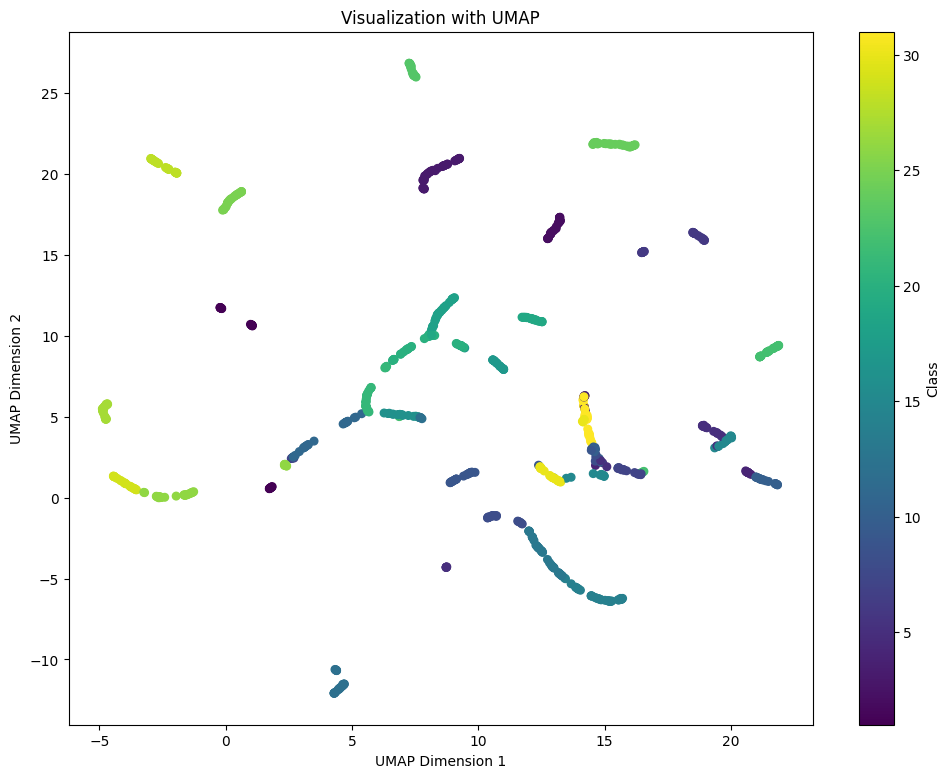

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/latent_space_LDA.png


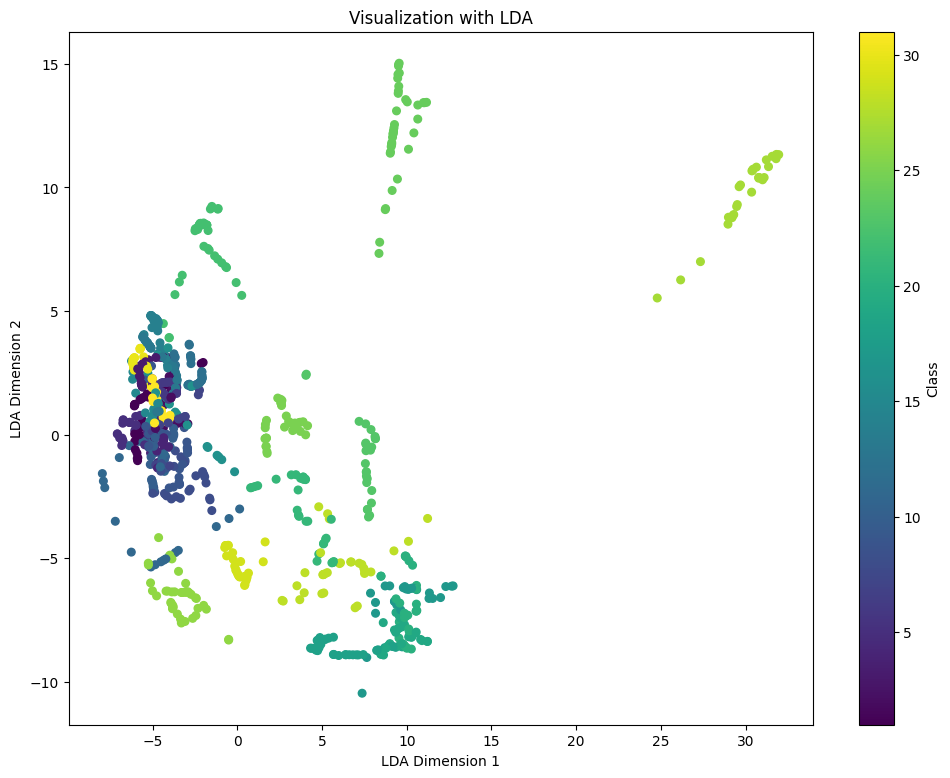

In [38]:
plot_latent_space(latent_representations, sampled_labels, techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path)

In [39]:
sampled_data.shape

(1000, 300, 7)

In [40]:
generation.shape

TensorShape([100, 300, 7])

35/35 [==============================] - 0s 1ms/step
Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/combined_latent_space_PCA.png


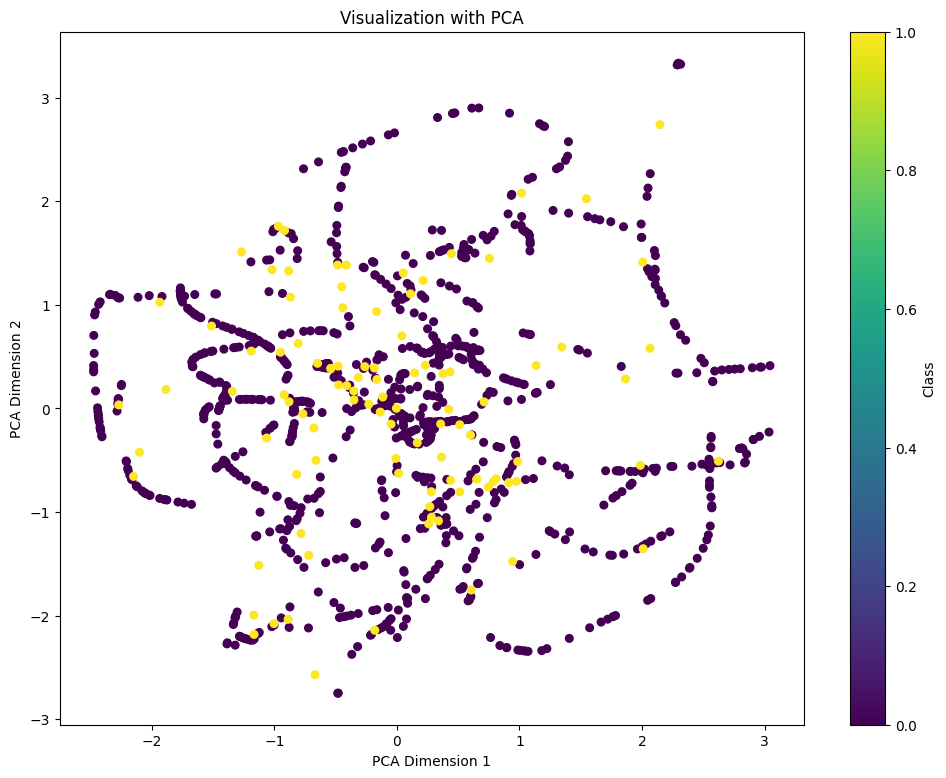

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/combined_latent_space_t-SNE.png


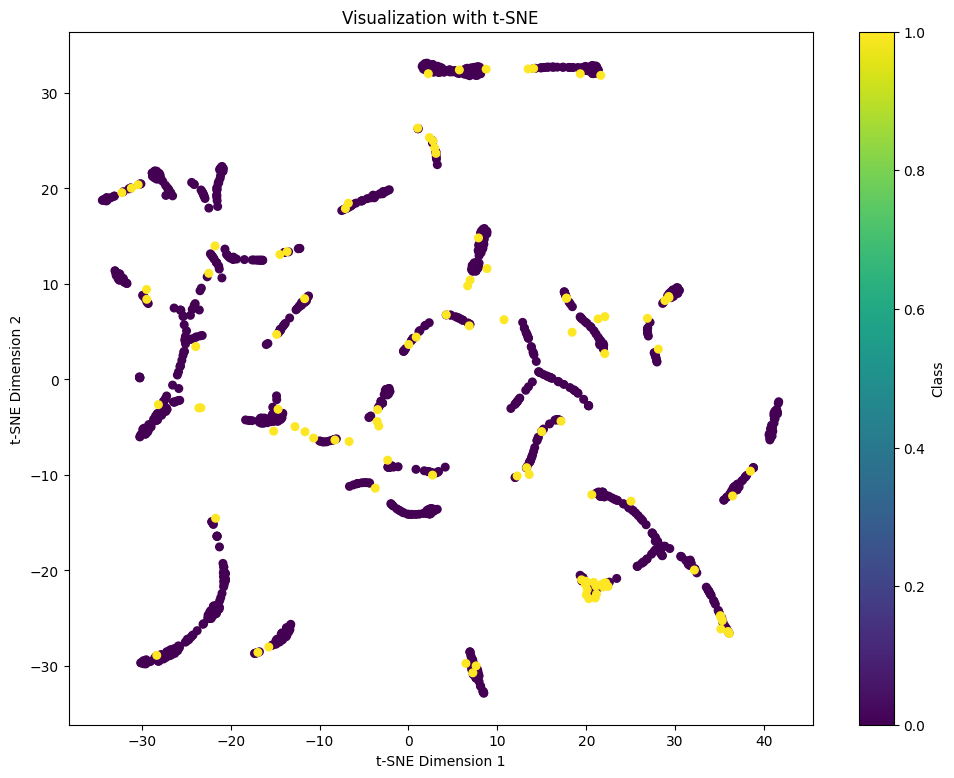

Saved plot to ../experiments/vae_conv5/1p_dataset_em/32_7_300_32_25_Adam_0.001/combined_latent_space_UMAP.png


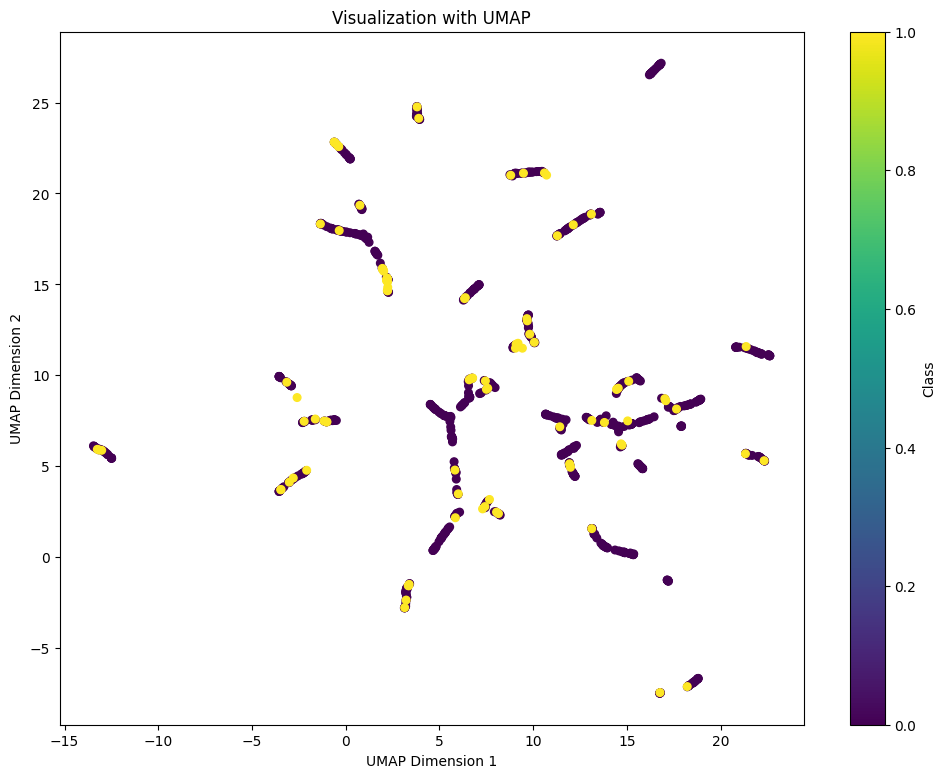

In [41]:
plot_combined_latent_space(sampled_data, generation, encoder, ['PCA','t-SNE','UMAP'], save_path=combined_latent_space_path)

In [42]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
kl_loss,█▇▆▅▃▃▃▃▂▂▂▁▂▁▁▁▂▁▂▂▁▁▁▂▁
loss,█▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
kl_loss,10.70042
loss,20.29341
reconstruction_loss,9.59131
